<a href="https://colab.research.google.com/github/SupermarketAutomationAI/bounding_box/blob/main/SupermarketAI_BoundingBox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import all Libraries needed for this Notebook

In [ ]:
import os
import json
import math
import shutil
from glob import glob

import torch
import torch.nn as nn
import torch.optim as optim 
import torch.nn.functional as F
import torchvision.models
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import time
import itertools
from sklearn.metrics import confusion_matrix

#from models import *
#from utils import *
import sys, datetime, random
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.patches as patches
from PIL import Image

import tensorflow as tf
import torchvision.transforms as T
import cv2

# Data Loading, Splitting, and Processing

This Jupyter notebook section contains the data processing for data processing for the sanity checks. The format of this version is as follows:

/V3_combined_all_DS
```
/train
  Banana
  Red_Delicious_Apple
  Orange
  .
  .
/val
  Banana
  Red_Delicious_Apple
  Orange
  .
  .
/test
  Banana
  Red_Delicious_Apple
  Orange
  .
  .
```
Where each of the above subdirectories in train, val, and test are their own class. In this version, there is one class for each type of fruit, and there are 19 fruit classes.

Classes: 

['Bananas', 'Carambola', 'Fuji Apples', 'Gala Apples', 'Golden Delicious Apples', 'Granny Smith Apples', 'Guava', 'Kiwi', 'Mango', 'Muskmelo', 'Oranges', 'Peach', 'Pear', 'Persimmon', 'Pitaya', 'Plum', 'Pomegranate', 'Red Delicious Apples', 'Tomatoes']

## Load the Data

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! rm -rf /root/datasets/V3_combined_all_DS/

In [ ]:
! unzip -uq '/content/drive/MyDrive/APS360 Project/Dataset Zip Files/V3_combined_all_DS-1.zip' -d '/root/datasets/'

In [122]:
# Clean the data, remove the metadate image files, marked with "._" in names
parent_dir = "/root/datasets/V3_combined_all_DS"

classes = ['Bananas', 'Carambola', 'Fuji Apples', 'Gala Apples', 'Golden Delicious Apples', 
           'Granny Smith Apples', 'Guava', 'Kiwi', 'Mango', 'Muskmelon', 'Oranges', 'Peach', 
           'Pear', 'Persimmon', 'Pitaya', 'Plum', 'Pomegranate', 'Red Delicious Apples', 
           'Tomatoes']

for cat in classes:
    path = parent_dir + '/' + cat
    invalid_files = glob(os.path.join(path,"._*"))
    for file_ in invalid_files:
        os.remove(file_)
    invalid_files = glob(os.path.join(path," ._*"))
    for file_ in invalid_files:
        os.remove(file_)
    print("Deleted image metadata files from {}".format(path))

Deleted image metadata files from /root/datasets/V3_combined_all_DS/Bananas
Deleted image metadata files from /root/datasets/V3_combined_all_DS/Carambola
Deleted image metadata files from /root/datasets/V3_combined_all_DS/Fuji Apples
Deleted image metadata files from /root/datasets/V3_combined_all_DS/Gala Apples
Deleted image metadata files from /root/datasets/V3_combined_all_DS/Golden Delicious Apples
Deleted image metadata files from /root/datasets/V3_combined_all_DS/Granny Smith Apples
Deleted image metadata files from /root/datasets/V3_combined_all_DS/Guava
Deleted image metadata files from /root/datasets/V3_combined_all_DS/Kiwi
Deleted image metadata files from /root/datasets/V3_combined_all_DS/Mango
Deleted image metadata files from /root/datasets/V3_combined_all_DS/Muskmelon
Deleted image metadata files from /root/datasets/V3_combined_all_DS/Oranges
Deleted image metadata files from /root/datasets/V3_combined_all_DS/Peach
Deleted image metadata files from /root/datasets/V3_combi

## Split the data

In [118]:
# create data directory and move all images into it
parent_dir = "/root/datasets/V3_combined_all_DS"
os.chdir(parent_dir)
category_list = list(filter(lambda x: os.path.isdir(x), os.listdir()))
data_dir = parent_dir + '/' + "data"
os.mkdir(data_dir, 755)
for category in category_list:
    cat_dir = parent_dir + '/' + category
    shutil.move(cat_dir, data_dir)

In [119]:
train_split = 0.6

dataset_dirs= ['train','val','test']
for dsdirs in dataset_dirs:
 path = parent_dir + '/'+ dsdirs
 os.mkdir( path,755 )

for category in category_list: 
    src_path = parent_dir + '/data/' + category
    train_dir = parent_dir + '/train/' + category + '/'
    val_dir = parent_dir + '/val/' + category + '/'
    test_dir = parent_dir + '/test/' + category + '/'
    
    os.mkdir(train_dir, 755 )
    os.mkdir(val_dir, 755)
    os.mkdir(test_dir, 755)

    #get files' names list from respective directories
    os.chdir(src_path)
    files = [f for f in os.listdir() if os.path.isfile(f)]

    #get training, testing and validation files count
    train_count = math.ceil(train_split*len(files))
    valid_count = int((len(files)-train_count)/2)
    test_count = valid_count

    #get files to segragate for train,test and validation data set
    train_data_list = files[0: train_count-1]
    valid_data_list = files[train_count:train_count+valid_count-1] 
    test_data_list = files[train_count+valid_count:]


    for train_data in train_data_list:
        train_path = src_path + '/' + train_data
        shutil.move(train_path,train_dir)

    for valid_data in valid_data_list:
        valid_path = src_path + '/' + valid_data
        shutil.move(valid_path,val_dir)

    for test_data in test_data_list:
        test_path = src_path + '/' + test_data
        shutil.move(test_path,test_dir)

    # Move any files that are left behind into the training directory
    os.chdir(src_path)
    files = [f for f in os.listdir() if os.path.isfile(f)]
    for img_left_behind in files:
        img_path = src_path + '/' + img_left_behind
        shutil.move(img_path, train_dir)

## Preprocess data into torch.datasets

In [120]:
# define the locations of the training and validation data
train_dir = os.path.join(parent_dir, 'train/')
val_dir = os.path.join(parent_dir, 'val/')
test_dir = os.path.join(parent_dir, 'test/')

# define a list of all classes that the model will be trained with

# List different classes: 19 currently
classes = ['Bananas', 'Carambola', 'Fuji Apples', 'Gala Apples', 'Golden Delicious Apples', 
           'Granny Smith Apples', 'Guava', 'Kiwi', 'Mango', 'Muskmelon', 'Oranges', 'Peach', 
           'Pear', 'Persimmon', 'Pitaya', 'Plum', 'Pomegranate', 'Red Delicious Apples', 
           'Tomatoes']

data_CC_transform = transforms.Compose([transforms.CenterCrop([224,224]), transforms.ToTensor()])

# apply the transforms to the data
train_data = datasets.ImageFolder(train_dir, transform=data_CC_transform)
val_data = datasets.ImageFolder(val_dir, transform=data_CC_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_CC_transform)

# print the amount of data in both training and validation sets
print("Amount of training data: ", len(train_data))
print("Amount of validation data: ", len(val_data))
print("Amount of test data: ", len(test_data))

Amount of training data:  35113
Amount of validation data:  11668
Amount of test data:  11696


In [121]:
# View 20 random, post processed, training images
fig = plt.figure(figsize=(32, 4)) 
train_loader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=True)

n=1
for data in iter(train_loader):
  img,label = data
  if n <= 20:
    image = img.numpy()
    ax = fig.add_subplot(2, 20/2, n, xticks=[], yticks=[])
    plt.imshow(np.transpose(image[0], (1, 2, 0)))
    ax.set_title(classes[label])
    n = n+1

UnidentifiedImageError: ignored

<Figure size 2304x288 with 0 Axes>

# Model Building, Training, and Testing

In [ ]:
alexnet = torchvision.models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


In [ ]:
# set the batch_size
batch_size = 1
parent_dir = "/root/datasets/V2_combinedDS"

# define the locations of the training and validation data
train_dir = os.path.join(parent_dir, 'train/')
val_dir = os.path.join(parent_dir, 'val/')
test_dir = os.path.join(parent_dir, 'test/')

# define a list of all classes that the model will be trained with
classes = ['Banana', 'Fuji_Apple', 'Gala_Apple', 'Golden_Delicious_Apple', 'Granny_Smith_Apple', 'Orange',
           'Red_Delicious_Apple']

# three possible transforms, will test each to see which gives better results
data_CC_transform = transforms.Compose([transforms.CenterCrop([224,224]), transforms.ToTensor()])

# apply the transforms to the data
train_data = datasets.ImageFolder(train_dir, transform=data_CC_transform)
val_data = datasets.ImageFolder(val_dir, transform=data_CC_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_CC_transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

In [ ]:
# Artifical Neural Network - 7 output classes

torch.manual_seed(1) # set the random seed

class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.name = "ann"
        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        self.fc2 = nn.Linear(4096, 500)
        self.fc3 = nn.Linear(500, 50)
        self.fc4 = nn.Linear(50, 7)

    def forward(self, x):
        x = x.view(-1, 256 * 6 * 6) #flatten feature data
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [ ]:
parent_dir = "/root/datasets/V2_combinedDS_Features"
def ANNFeatures(loader, ds_type):
  # save features to folder as tensors
  n = 0
  for img, label in loader:
    features = alexnet.features(img)
    features_tensor = torch.from_numpy(features.detach().numpy())

    folder_name = parent_dir + '/' + ds_type + '/' + str(classes[label])
    print(folder_name)
    if not os.path.isdir(folder_name):
      os.mkdir(folder_name)
    torch.save(features_tensor.squeeze(0), folder_name + '/' + str(n) + '.tensor')
    n += 1

In [ ]:
parent_dir = "/root/datasets/V2_combinedDS_Features"
if not os.path.isdir(parent_dir):
    os.mkdir(parent_dir)

train_dir = "/root/datasets/V2_combinedDS_Features/train"
if not os.path.isdir(train_dir):
    os.mkdir(train_dir)

val_dir = "/root/datasets/V2_combinedDS_Features/val"
if not os.path.isdir(val_dir):
    os.mkdir(val_dir)

test_dir = "/root/datasets/V2_combinedDS_Features/test"
if not os.path.isdir(test_dir):
    os.mkdir(test_dir)

# setting batch size to be 1 to load images one by one
batch_size = 1
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

In [ ]:
ANNFeatures(train_loader, 'train')
ANNFeatures(val_loader, 'val')
ANNFeatures(test_loader, 'test')

In [ ]:
def train(model, train_loader, val_loader, batch_size=128, num_epochs=64, learn_rate = 0.001):

    torch.manual_seed(1000)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learn_rate)
    
    train_acc, val_acc, epochs, train_loss_list, val_loss_list = [], [], [], [], []

    # training
    print ("Training Started...")
    start_time = time.time()
    n = 0 # the number of iterations
    epoch_num = 0
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
            out = model(imgs)             # forward pass
            train_loss = criterion(out, labels) # compute the total train_loss
            train_loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch
            n += 1

        for imgs, labels in iter(train_loader):
            out = model(imgs)             # forward pass
            val_loss = criterion(out, labels) # compute the total train_loss

        # track the accuracy
        epoch_num += 1
        epochs.append(epoch_num)
        average_train_loss = (float(train_loss))/batch_size
        train_loss_list.append(average_train_loss)
        average_val_loss = (float(val_loss))/batch_size
        val_loss_list.append(average_val_loss) 
        train_acc.append(get_accuracy(model, train_loader))
        val_acc.append(get_accuracy(model, val_loader))
        print("Epoch: {}, Training Accuracy: {:.2f}%, Training Loss: {:.2f}, Validation Accuracy: {:.2f}%, Validation Loss: {:.2f}".format(epoch, train_acc[-1]*100, train_loss_list [-1], val_acc[-1]*100, val_loss_list[-1]))
    # checkpointing
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(model.name,batch_size,learn_rate,epoch)
    torch.save(model.state_dict(), path)
    
    # plots
    plt.title("Loss Curve")
    plt.plot(epochs, train_loss_list, label="Train")
    plt.plot(epochs, val_loss_list, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Learning Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    end_time = time.time()
    print("Training took {:.2f}\n".format(end_time - start_time))
    print("Final training accuracy: {:.2f}%\n".format(train_acc[-1]*100))
    print("Final validation accuracy: {:.2f}%\n".format(val_acc[-1]*100))

In [ ]:
def get_accuracy(model, data_loader):
    correct = 0
    total = 0
    if (len(data_loader)==0):
      return
    for imgs, labels in data_loader:

        output = model(imgs)
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [ ]:
train_path = '/root/datasets/V2_combinedDS_Features/train'
train_features = torchvision.datasets.DatasetFolder(train_path, loader=torch.load, extensions=('.tensor'))

val_path = '/root/datasets/V2_combinedDS_Features/val'
val_features = torchvision.datasets.DatasetFolder(val_path, loader=torch.load, extensions=('.tensor'))

test_path = '/root/datasets/V2_combinedDS_Features/test'
test_features = torchvision.datasets.DatasetFolder(test_path, loader=torch.load, extensions=('.tensor'))

# Prepare Dataloader
batch_size = 64
num_workers = 1
train_feature_loader = torch.utils.data.DataLoader(train_features, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

val_features_loader = torch.utils.data.DataLoader(val_features, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

test_features_loader = torch.utils.data.DataLoader(test_features, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

# Verification Step - obtain one batch of features
dataiter = iter(train_feature_loader)
features, labels = dataiter.next()
print(features.shape)
print(labels.shape)

torch.Size([64, 256, 6, 6])
torch.Size([64])


Training Started...
Epoch: 0, Training Accuracy: 99.93%, Training Loss: 0.00, Validation Accuracy: 99.65%, Validation Loss: 0.00
Epoch: 1, Training Accuracy: 100.00%, Training Loss: 0.00, Validation Accuracy: 99.96%, Validation Loss: 0.00
Epoch: 2, Training Accuracy: 100.00%, Training Loss: 0.00, Validation Accuracy: 99.96%, Validation Loss: 0.00
Epoch: 3, Training Accuracy: 100.00%, Training Loss: 0.00, Validation Accuracy: 100.00%, Validation Loss: 0.00
Epoch: 4, Training Accuracy: 100.00%, Training Loss: 0.00, Validation Accuracy: 99.96%, Validation Loss: 0.00


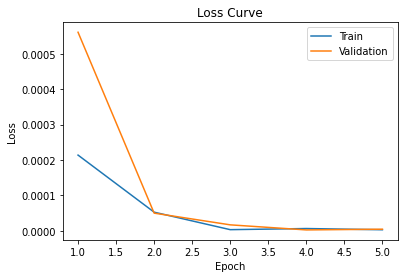

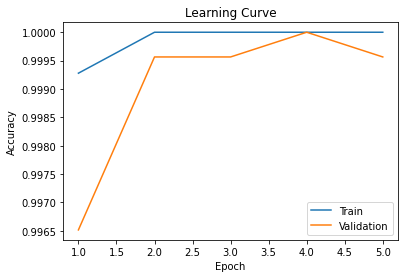

Training took 397.31

Final training accuracy: 100.00%

Final validation accuracy: 99.96%



In [ ]:
# Training with 5 epochs, learning rate of 0.0001, batch size = 64
SupermarketAI_V2DS_V1_Model = ANN()
train(SupermarketAI_V2DS_V1_Model, train_feature_loader, val_features_loader, num_epochs=5, learn_rate=0.0001, batch_size=64)

# Verification of Model Quantitative Results 

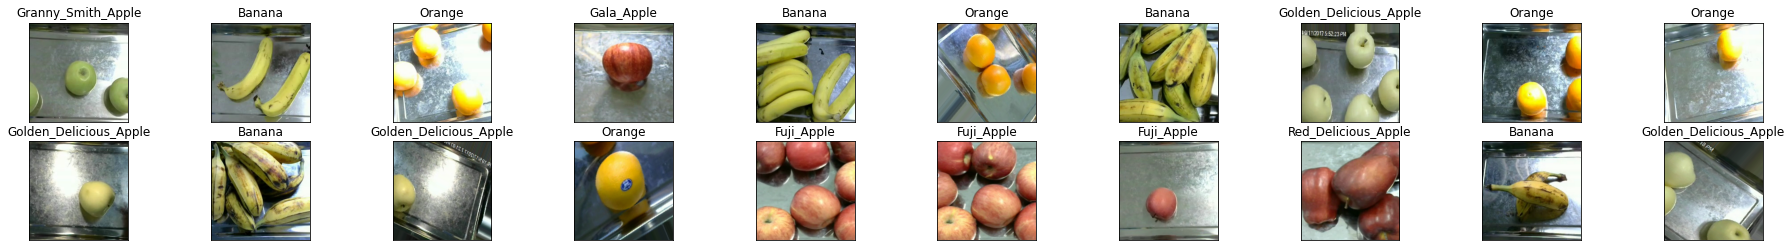

In [ ]:
fig = plt.figure(figsize=(32, 4)) 
train_verif_loader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=True)
val_verif_loader = torch.utils.data.DataLoader(val_data, batch_size=1, shuffle=True)
n=1

for imgs, labels in iter(val_verif_loader):
  if n <= 20:
    # verification step
    image = imgs.numpy() #convert to numpy for display
    ax = fig.add_subplot(2, 20/2, n, xticks=[], yticks=[])
    plt.imshow(np.transpose(image[0], (1, 2, 0)))
    out = SupermarketAI_V2DS_V1_Model(alexnet.features(imgs))
    pred = out.max(1, keepdim=True)[1]
    ax.set_title(classes[pred[0]])
    n = n+1

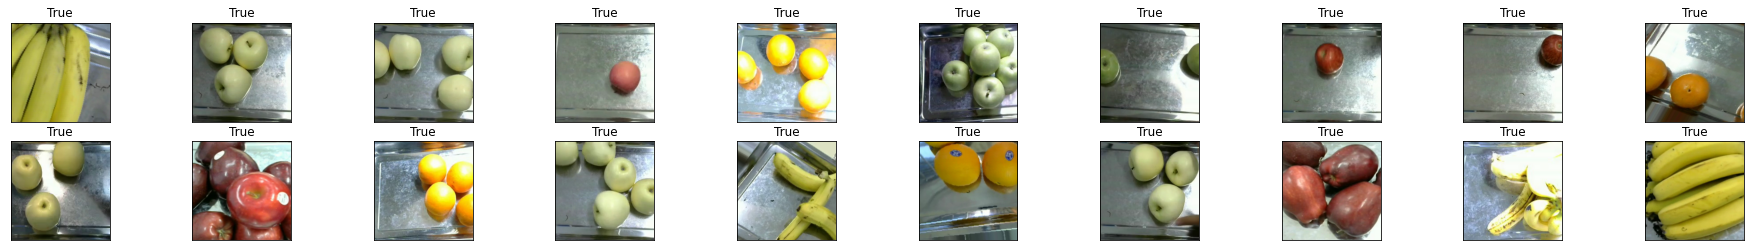

In [ ]:
import numpy as np
fig = plt.figure(figsize=(32, 4)) 
train_verif_loader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=True)
val_verif_loader = torch.utils.data.DataLoader(val_data, batch_size=1, shuffle=True)
n=1

for imgs, labels in iter(val_verif_loader):
  if n <= 20:
    # verification step
    image = imgs.numpy() #convert to numpy for display
    ax = fig.add_subplot(2, 20/2, n, xticks=[], yticks=[])
    plt.imshow(np.transpose(image[0], (1, 2, 0)))
    out = SupermarketAI_V2DS_V1_Model(alexnet.features(imgs))
    pred = out.max(1, keepdim=True)[1]
    ax.set_title(classes[pred[0]] == classes[labels])
    n = n+1

In [ ]:
fig = plt.figure(figsize=(32, 4)) 
train_verif_loader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=True)
val_verif_loader = torch.utils.data.DataLoader(val_data, batch_size=1, shuffle=True)
start = time.time()
n = 1
pred_list = []
actual_labels = []
for imgs, labels in iter(val_verif_loader):
  out = SupermarketAI_V2DS_V1_Model(alexnet.features(imgs))
  pred = out.max(1, keepdim=True)[1]
  pred_list.append(classes[pred[0]])
  actual_labels.append(classes[labels])
  if n <= 20:
    # verification step

    if (classes[pred[0]] != classes[labels]):
      image = imgs.numpy() #convert to numpy for display
      ax = fig.add_subplot(2, 20/2, n, xticks=[], yticks=[])
      plt.imshow(np.transpose(image[0], (1, 2, 0)))
      ax.set_title(classes[pred[0]])
      n = n+1
end = time.time()
duration = end - start
print(duration)
confusion_matrix(actual_labels, pred_list)


121.94917011260986


array([[603,   0,   0,   0,   0,   0,   0],
       [  0, 137,   0,   0,   0,   0,   0],
       [  0,   0, 199,   0,   0,   0,   0],
       [  0,   0,   0, 405,   0,   0,   0],
       [  0,   0,   0,   0, 204,   0,   0],
       [  0,   0,   0,   0,   0, 601,   0],
       [  0,   0,   0,   0,   0,   0, 147]])

<Figure size 2304x288 with 0 Axes>

Confusion matrix, without normalization
[[603   0   0   0   0   0   0]
 [  0 137   0   0   0   0   0]
 [  0   0 199   0   0   0   0]
 [  0   0   0 405   0   0   0]
 [  0   0   0   0 204   0   0]
 [  0   0   0   0   0 601   0]
 [  0   0   0   0   0   0 147]]


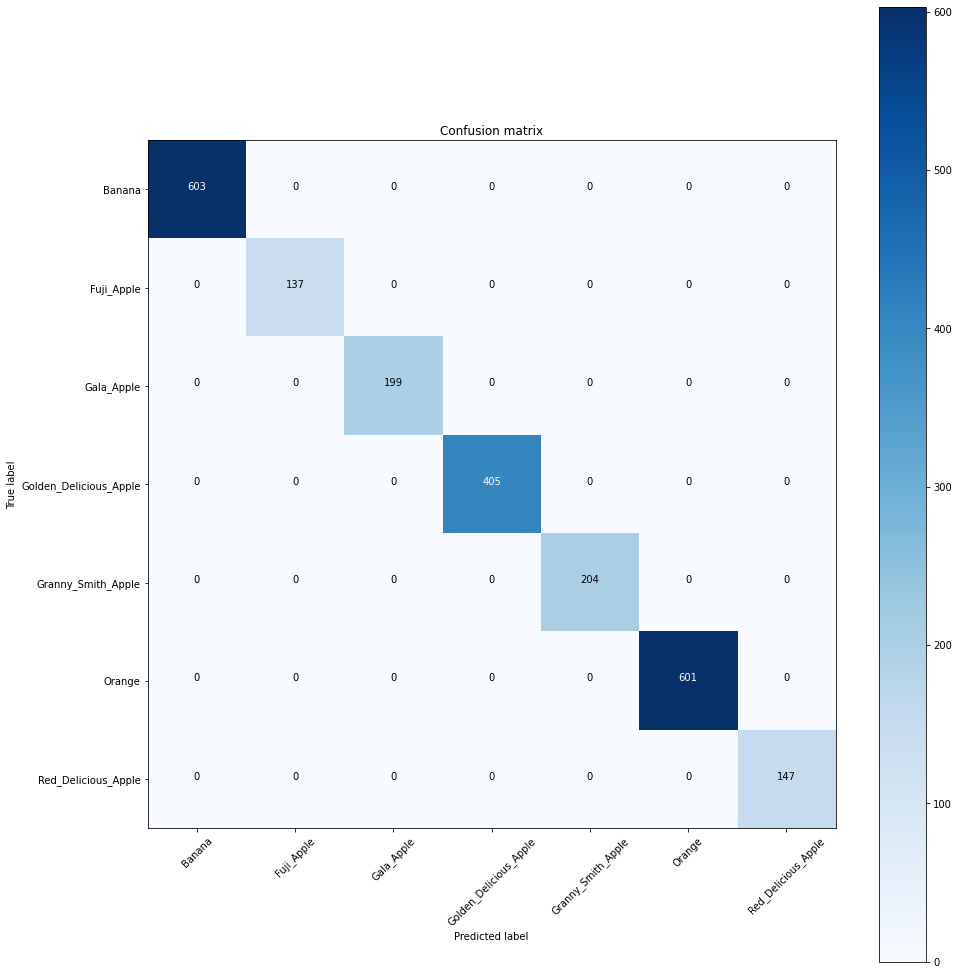

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm = confusion_matrix(actual_labels, pred_list)
plt.figure(figsize=(14,14))
plot_confusion_matrix(cm, classes)

# Supermarket AI Integration with Bounding Boxes

In [ ]:
# Store classes into a file
parent_dir = "/root/datasets/V2_combinedDS"
model_info_dir = parent_dir + '/' + "ds_info"
if not os.path.isdir(model_info_dir):
    os.mkdir(model_info_dir)
model_class_info_file_path = model_info_dir + '/' + 'model_classes.txt'
model_classes_file = open(model_class_info_file_path, "w+")
for cat in classes:
    model_classes_file.write(cat + "\n")
model_classes_file.close()

In [ ]:
#config_path='config/yolov3.cfg'
#weights_path='yolov3.weights'
class_path = model_class_info_file_path
img_size=224
conf_thres=0.8
nms_thres=0.4
# Load model and weights
model = SupermarketAI_V2DS_V1_Model
model.cuda()
model.eval()
classes = classes#utils.load_classes(class_path)
Tensor = torch.cuda.FloatTensor

In [ ]:
def detect_image(img, model):
    # scale and pad image
    ratio = min(img_size/img.shape[-1], img_size/img.shape[-2])
    imw = round(img.shape[-1] * ratio)
    imh = round(img.shape[-2] * ratio)
    img_transforms = transforms.Compose([ transforms.Resize((imh, imw)),
         transforms.Pad((max(int((imh-imw)/2),0), max(int((imw-imh)/2),0), max(int((imh-imw)/2),0), max(int((imw-imh)/2),0)),
                        (128,128,128)),transforms.ToTensor(),])
    # convert image to Tensor
    #image_tensor = img_transforms(img).float()
    #image_tensor = image_tensor.unsqueeze_(0)
    #input_img = Variable(image_tensor.type(Tensor))
    # run inference on the model and get detections
    with torch.no_grad():
        detections = model(img)
        detections = utils.non_max_suppression(detections, 80, conf_thres, nms_thres)
    return detections[0]

In [ ]:
parent_dir = "/root/datasets/V2_combinedDS"
train_dir = os.path.join(parent_dir, 'train/')
train_data = datasets.ImageFolder(train_dir, transform=data_CC_transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=1)
img_path = train_loader.dataset.imgs[0][0]
prev_time = time.time()
#img = Image.open(img_path)
n = 0
for img, label in iter(train_loader):
    detections = detect_image(img, model)
    if (n > 1):
      break
    n += 1

In [ ]:
# load image and get detections
# img_path = "images/blueangels.jpg"
parent_dir = "/root/datasets/V2_combinedDS"
train_dir = os.path.join(parent_dir, 'train/')
train_data = datasets.ImageFolder(train_dir, transform=data_CC_transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
img_path = train_loader.dataset.imgs[0][0]
prev_time = time.time()
#img = Image.open(img_path)
n = 0
for img, label in iter(train_loader):
    detections = detect_image(img, model)
    if (n > 1):
      break
    n += 1
inference_time = datetime.timedelta(seconds=time.time() - prev_time)
print ('Inference Time: %s' % (inference_time))

# Get bounding-box colors
cmap = plt.get_cmap('tab20b')
colors = [cmap(i) for i in np.linspace(0, 1, 20)]

img = np.array(img)
plt.figure()
fig, ax = plt.subplots(1, figsize=(12,9))
ax.imshow(img)

pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
unpad_h = img_size - pad_y
unpad_w = img_size - pad_x

if detections is not None:
    unique_labels = detections[:, -1].cpu().unique()
    n_cls_preds = len(unique_labels)
    bbox_colors = random.sample(colors, n_cls_preds)
    # browse detections and draw bounding boxes
    for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:
        box_h = ((y2 - y1) / unpad_h) * img.shape[0]
        box_w = ((x2 - x1) / unpad_w) * img.shape[1]
        y1 = ((y1 - pad_y // 2) / unpad_h) * img.shape[0]
        x1 = ((x1 - pad_x // 2) / unpad_w) * img.shape[1]
        color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
        bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(bbox)
        plt.text(x1, y1, s=classes[int(cls_pred)], color='white', verticalalignment='top',
                bbox={'color': color, 'pad': 0})
plt.axis('off')
# save image
plt.savefig(img_path.replace(".jpg", "-det.jpg"), bbox_inches='tight', pad_inches=0.0)
plt.show()

# Faster R-CNN

In [ ]:
#https://www.learnopencv.com/faster-r-cnn-object-detection-with-pytorch/
import torchvision
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

In [ ]:
def get_prediction(img_path, threshold):
    img = Image.open(img_path) # Load the image
    transform = T.Compose([T.ToTensor()]) # Defing PyTorch Transform
    img = transform(img) # Apply the transform to the image
    pred = model([img]) # Pass the image to the model
    #pred_class = [FRUIT_RECOG_CATEGORY_NAMESV2[i] for i in list(pred[0]['labels'].numpy())] # Get the Prediction Score
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())] # Bounding boxes
    pred_score = list(pred[0]['scores'].detach().numpy())
    pred_t = [pred_score.index(x) for x in pred_score if x > threshold][-1] # Get list of index with score greater than threshold.
    pred_boxes = pred_boxes[:pred_t+1]
    #pred_class = pred_class[:pred_t+1]
    return pred_boxes#, pred_class

In [ ]:
! ls /root/datasets/V2_combinedDS/train/Gala_Apple/Gala\ Apple\ 00001\ 2.png/

'/root/datasets/V2_combinedDS/train/Red_Delicious_Apple/18Red Delicious Apple e06701.png'


In [106]:
def object_detection_api(img_path, model, threshold=0.5, rect_th=2, text_size=0.5, text_th=1):
  boxes = get_prediction(img_path, threshold) # Get predictions, took out 'pred_cls' after boxes
  img = cv2.imread(img_path) # Read image with cv2
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB
  
  classes = ['Banana', 'Fuji_Apple', 'Gala_Apple', 'Golden_Delicious_Apple', 'Granny_Smith_Apple', 'Orange',
           'Red_Delicious_Apple']

  transform = T.Compose([T.ToTensor()])
  img_tensor = transform(img)

  for i in range(len(boxes)):
    cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th) # Draw Rectangle with the coordinates
    top_left_y = int(boxes[i][0][1])
    top_left_x = int(boxes[i][0][0])
    height = int(abs(boxes[i][1][1] - boxes[i][0][1]))
    width = int(abs(boxes[i][1][0] - boxes[i][0][0]))
    img_cropped = T.functional.resized_crop(img_tensor, top_left_y, top_left_x, height, width, [224,224])
    img_cropped = img_cropped.unsqueeze(0)
    features = alexnet.features(img_cropped)
    out = model(features)
    print(out)
    pred_class = out.max(1, keepdim=True)[1]
    print(pred_class)
    cv2.putText(img,classes[pred_class[0]], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,0,0),thickness=text_th) # Write the prediction class
  
  plt.figure(figsize=(10,15)) # display the output image
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.show()

tensor([[-0.9432, -0.1320, -1.5042, -0.8650, -2.7874,  1.1639,  9.1181]],
       grad_fn=<AddmmBackward>)
tensor([[6]])


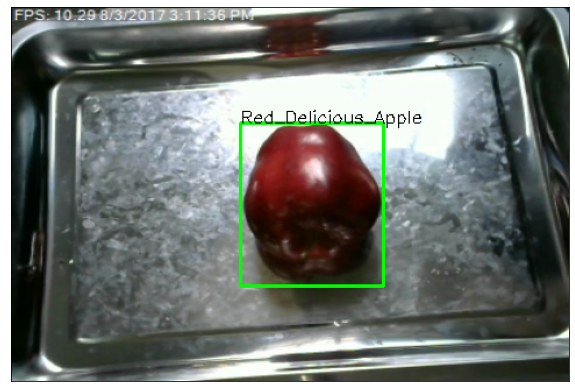

In [111]:
img_path = "/root/datasets/V2_combinedDS/train/Red_Delicious_Apple/107Red Delicious Apple e01001107.png"

object_detection_api(img_path, SupermarketAI_V2DS_V1_Model, threshold=0.8)
# Classifies all apples as red delicious apples?? Maybe an error in my code?